# İş Bankası - Menü Tavsiye Sistemi

## İçerik
* EDA- Veriyi anlamak ve görselleştirmek

* Feauture Engineering
* Ensemble Model

* Eğitilmiş modellerle tahminleme
  

### Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import log_loss
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score


#
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

gpu_available = True #True if you want to use GPU



### Veri Okuma

In [2]:
train = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/train_final.parquet')
test = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/test_final.parquet')

train.head()

,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.197737,1.113360,-1.123334,...,-2.613336,-2.032903,2.645719,-1.023478,1.658986,-1.559406,-2.161336,30,58,"menu2, menu4, menu5"
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,samsung,-2.336352,2.567766,-0.494908,...,-0.983938,-1.453756,-0.021547,-0.195770,2.775513,-0.318980,-4.291473,21,45,"menu7, menu8, menu4"
2,c82a7cbd2e00d9b66c06bcadc,10,3835.618,3275.128,43.806,TURK TELEKOM,Redmi,-2.561455,2.061736,-0.184511,...,-1.668703,-3.599403,1.673868,0.631790,1.293131,-2.230909,-2.383524,19,61,"menu2, menu8, menu4"
3,f2d2b25073ccc298eced86897,10,3532.544,154.509,64.724,TURKCELL,samsung,-2.529918,3.358050,-0.851366,...,-1.861418,-1.219658,1.863495,0.213170,1.029710,-1.142185,-4.466191,2,41,"menu6, menu2, menu1"
4,7818c92a58af0f2cb7c361738,10,3344.192,787.896,715.115,VODAFONE TR,samsung,-2.922361,2.096124,0.060796,...,-0.142903,-1.875545,1.024499,-0.186423,-0.061626,-1.462175,-2.371206,23,85,"menu6, menu2, menu8"


## EDA

In [3]:
print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

# Data types of columns
print(train.dtypes)

# Checking for missing values
missing_values = train.isnull().sum()
print(f'Number of missing values {len(missing_values[missing_values > 0])}')


Training Data Shape: (94049, 58)
Test Data Shape: (11955, 57)
id              object
month            int64
n_seconds_1    float64
n_seconds_2    float64
n_seconds_3    float64
carrier         object
devicebrand     object
feature_0      float64
feature_1      float64
feature_2      float64
feature_3      float64
feature_4      float64
feature_5      float64
feature_6      float64
feature_7      float64
feature_8      float64
feature_9      float64
feature_10     float64
feature_11     float64
feature_12     float64
feature_13     float64
feature_14     float64
feature_15     float64
feature_16     float64
feature_17     float64
feature_18     float64
feature_19     float64
feature_20     float64
feature_21     float64
feature_22     float64
feature_23     float64
feature_24     float64
feature_25     float64
feature_26     float64
feature_27     float64
feature_28     float64
feature_29     float64
feature_30     float64
feature_31     float64
feature_32     float64
feature_33     flo

In [4]:
train['target'] = train['target'].apply(lambda x: [item.strip(' ') for item in x.split(',')])
mlb = MultiLabelBinarizer()
target_transformed = mlb.fit_transform(train['target'])
target_df = pd.DataFrame(target_transformed, columns=mlb.classes_)

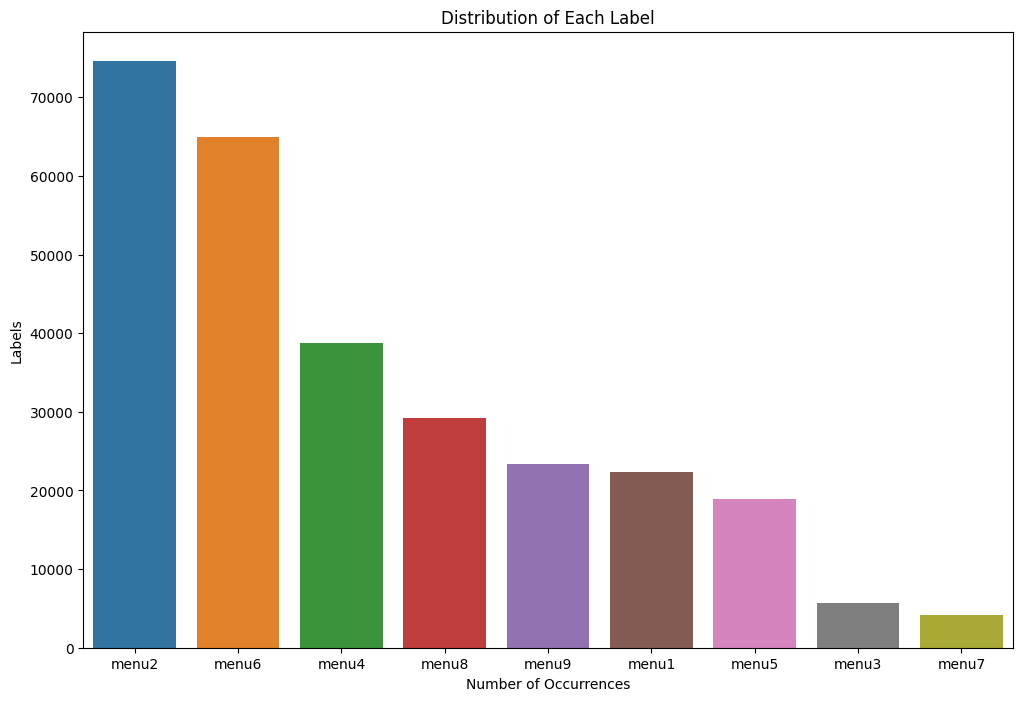

In [5]:
label_counts = target_df.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, orient='v')
plt.title('Distribution of Each Label')
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.show()


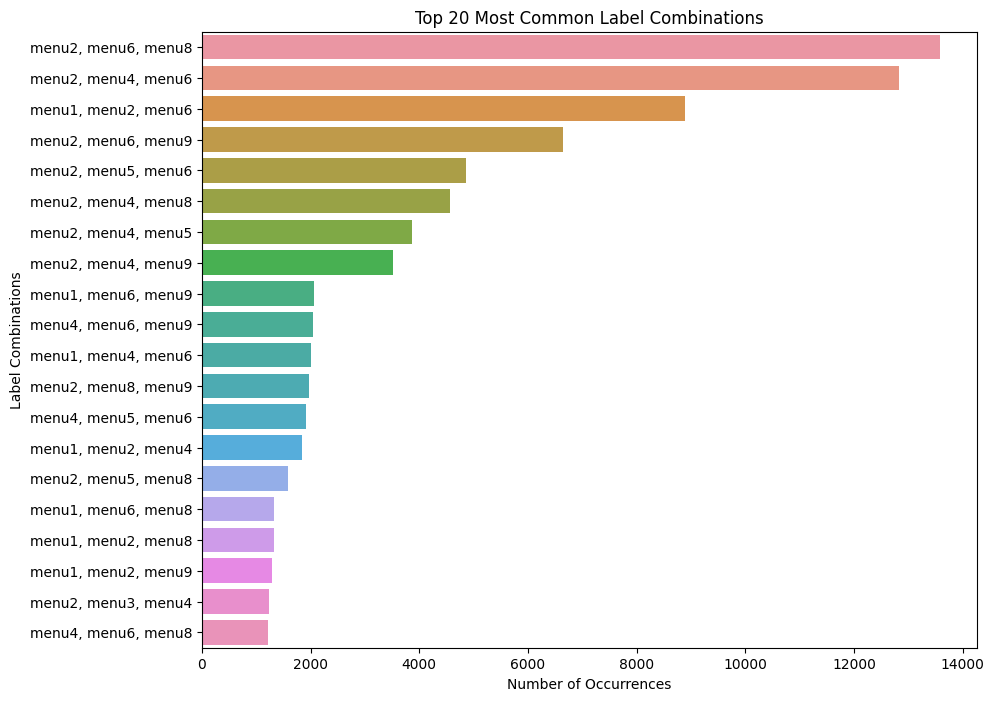

In [6]:
target_df['label_combination'] = target_df.apply(lambda row: ', '.join(row.index[row == 1]), axis=1)
common_combinations = target_df['label_combination'].value_counts()[:20]

plt.figure(figsize=(10, 8))
sns.barplot(y=common_combinations.index, x=common_combinations.values, orient='h')
plt.title('Top 20 Most Common Label Combinations')
plt.xlabel('Number of Occurrences')
plt.ylabel('Label Combinations')
plt.show()


In [7]:
train.describe()


,month,n_seconds_1,n_seconds_2,n_seconds_3,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,...,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000,94049.000000
mean,11.311561,432.781818,197.904016,102.381759,-1.824932,1.948002,-0.014231,-0.270988,3.428983,2.314612,...,1.055930,-1.247314,-1.863433,1.042226,0.260601,0.737817,-0.683078,-2.333848,20.531978,50.843943
std,0.732301,429.834018,169.474603,80.533643,0.706014,0.742521,0.855615,1.001878,0.886168,0.765429,...,0.745859,0.767093,0.812613,0.910212,0.797621,0.837250,0.858325,0.642435,8.310330,12.950021
min,10.000000,41.850000,40.231000,40.001000,-5.009604,-1.190684,-4.988702,-4.205721,-2.057158,-1.572397,...,-3.565546,-4.956211,-6.151754,-3.265827,-3.735571,-3.631153,-4.166801,-5.680349,1.000000,20.000000
25%,11.000000,181.540000,91.886000,53.746000,-2.290048,1.443627,-0.560076,-0.950880,2.891524,1.805311,...,0.587355,-1.736227,-2.396253,0.431905,-0.252991,0.161747,-1.279131,-2.753271,15.000000,41.000000
50%,11.000000,306.947000,144.874000,75.415000,-1.840876,1.934019,0.005703,-0.337732,3.503459,2.316267,...,1.093342,-1.219592,-1.865288,1.037332,0.285148,0.703326,-0.703813,-2.327645,21.000000,50.000000
75%,12.000000,537.064000,241.504000,119.032000,-1.379623,2.431059,0.559322,0.330430,4.050990,2.825116,...,1.565953,-0.732870,-1.333491,1.648791,0.798862,1.276491,-0.112671,-1.909460,26.000000,60.000000
max,12.000000,13567.046000,3275.128000,1476.077000,2.137354,6.574112,4.055067,5.021944,6.272530,5.775909,...,3.869422,2.830491,3.225738,5.322931,3.825793,5.147134,3.483374,1.401900,68.000000,102.000000


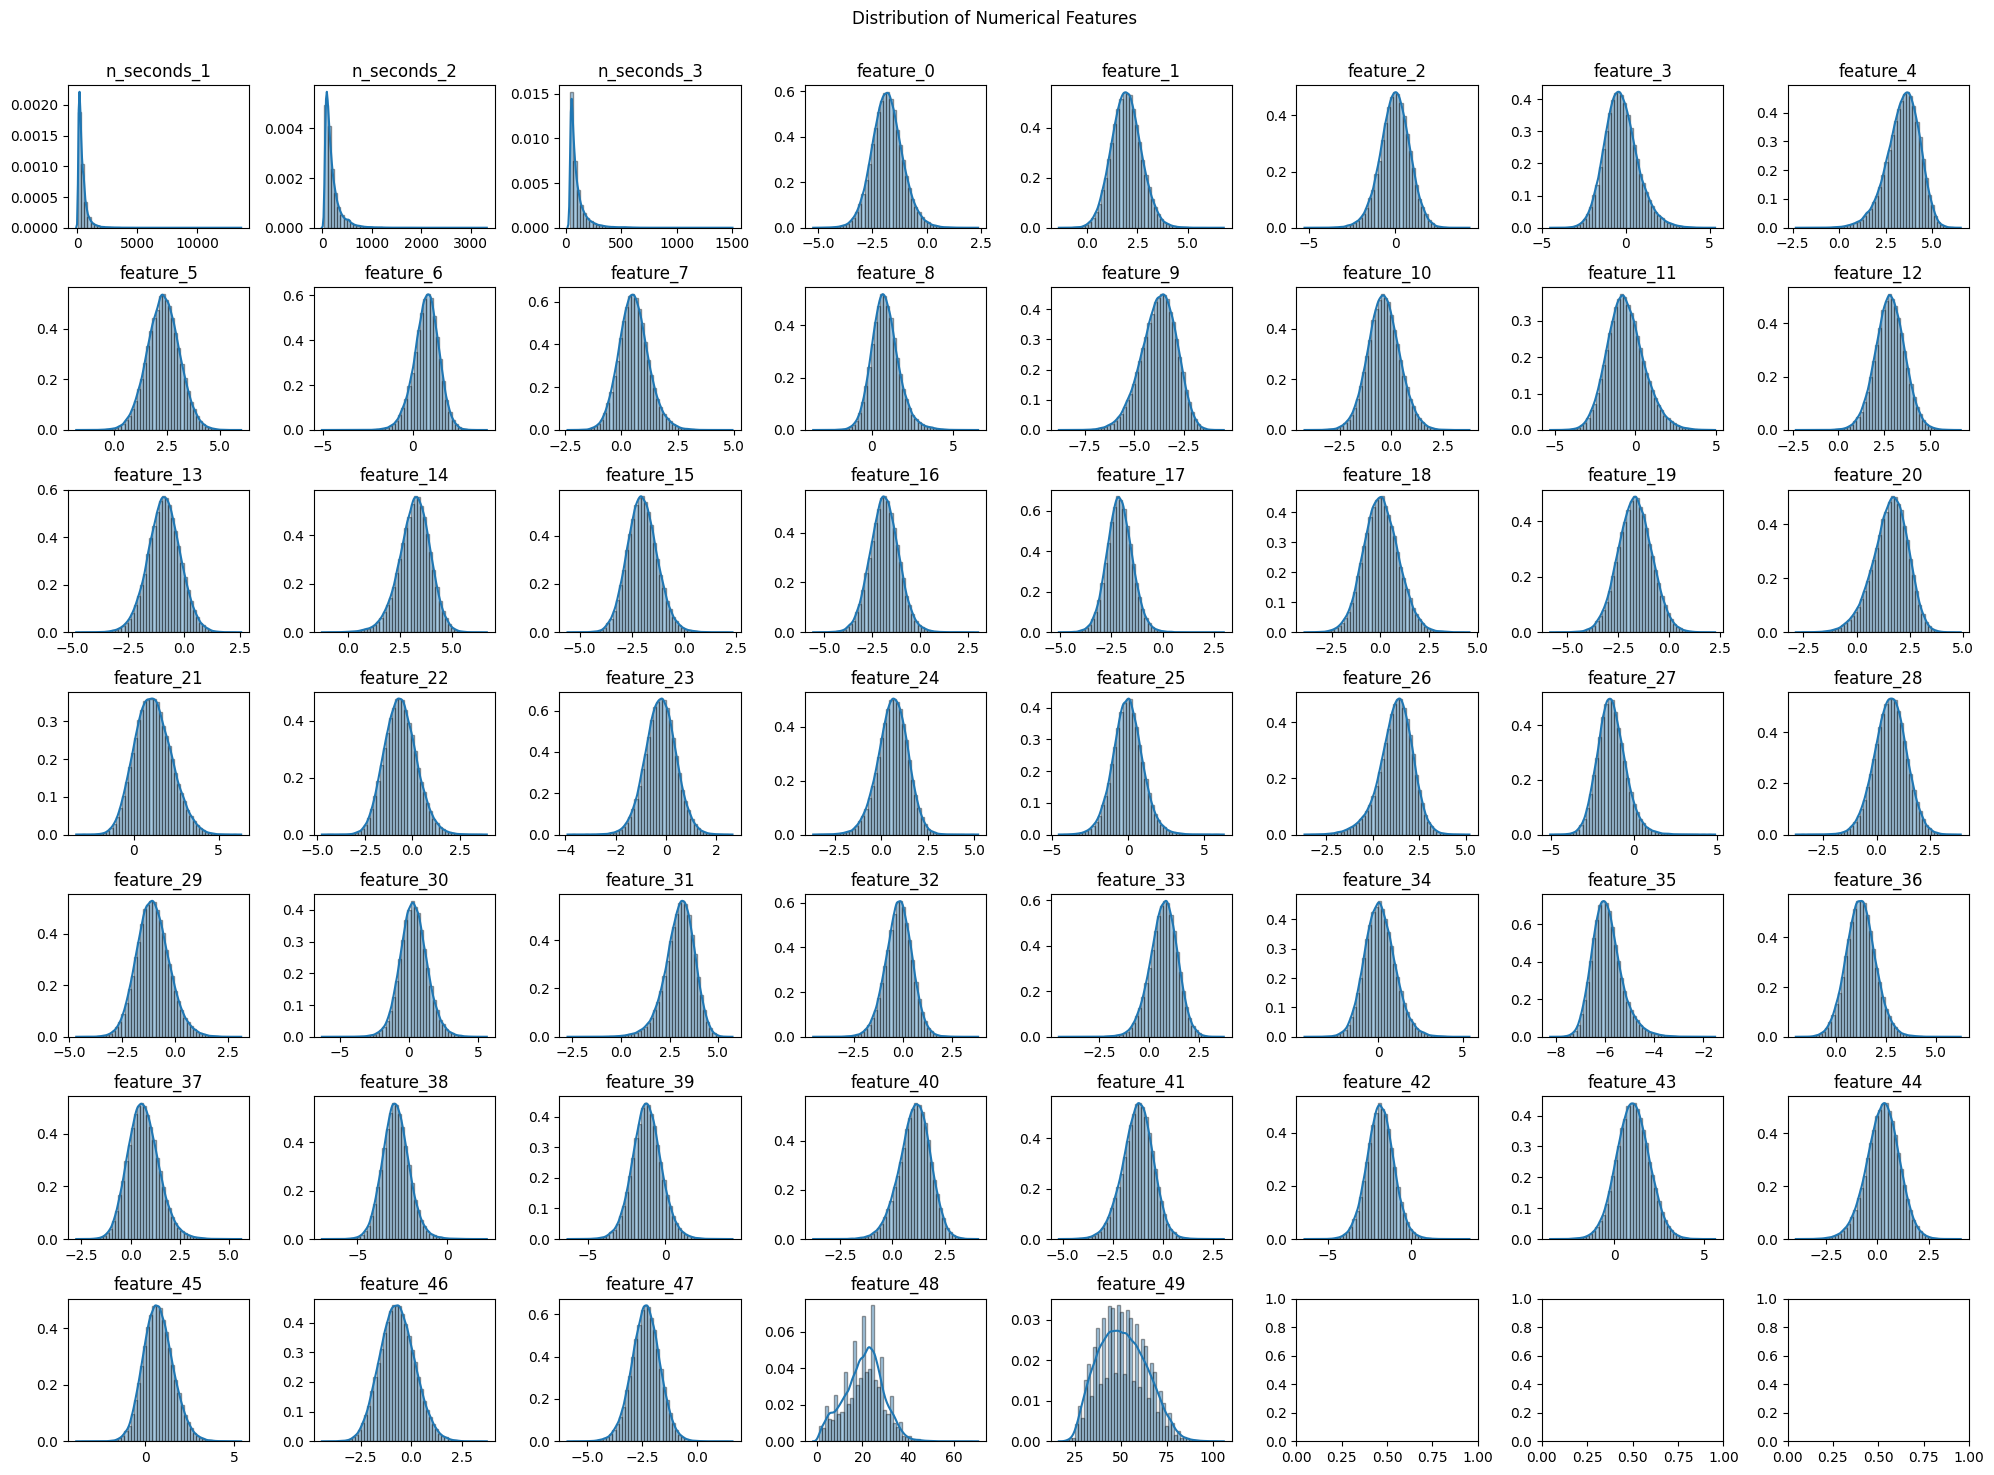

In [8]:
numerical_features = ['n_seconds_1', 'n_seconds_2', 'n_seconds_3',
       'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28',
       'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
       'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43',
       'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48',
       'feature_49']


fig, axes = plt.subplots(7, 8, figsize=(20, 15))
fig.suptitle('Distribution of Numerical Features')

# Flatten the 2D array of axes
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.distplot(train[feature], ax=axes[idx], kde=True, hist_kws={'edgecolor':'black'})
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')
    
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

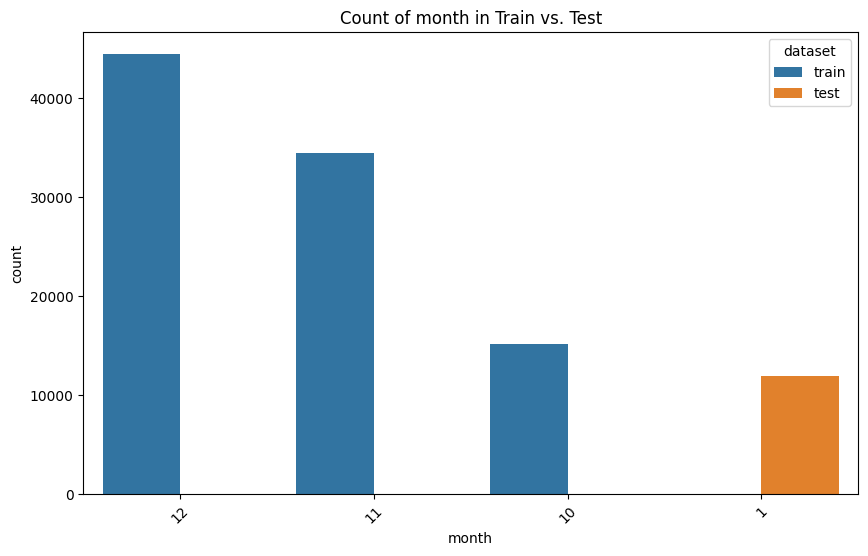

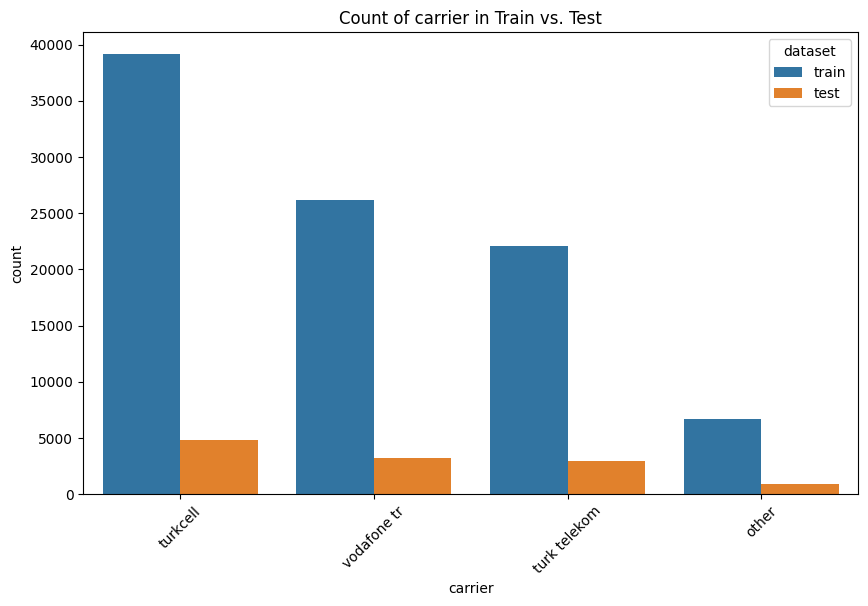

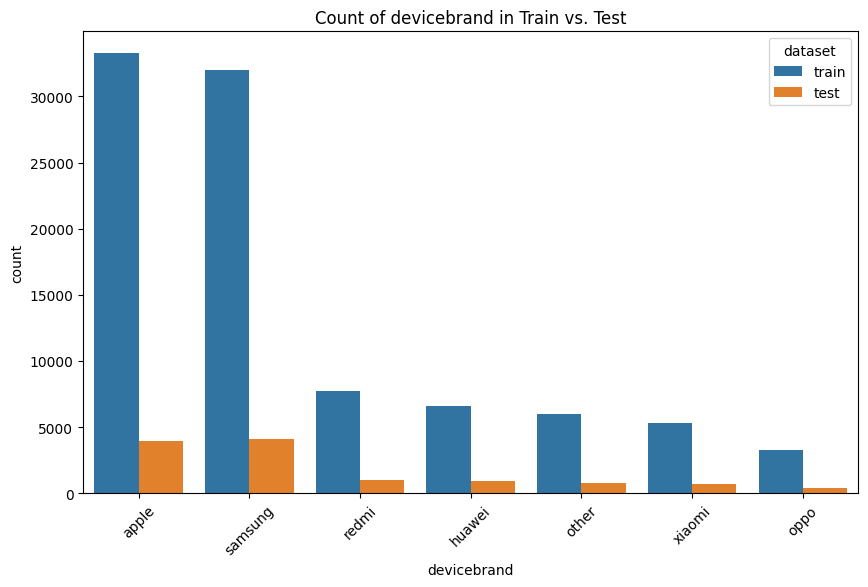

In [9]:
# Lowercase 'devicebrand' and 'carrier'
train['devicebrand'] = train['devicebrand'].str.lower()
train['carrier'] = train['carrier'].str.lower()
# Replace carrier names
train['carrier'] = train['carrier'].replace('vodafone', 'vodafone tr')
train['carrier'] = train['carrier'].replace('tr turkcell', 'turkcell')
    
# Keep only selected carriers and device brands
carriers_to_keep = ['turkcell', 'vodafone tr', 'turk telekom']
devicebrand_to_keep = ['apple', 'samsung', 'redmi', 'huawei', 'xiaomi', 'oppo']
train['carrier'] = train['carrier'].apply(lambda x: x if x in carriers_to_keep else 'other')
train['devicebrand'] = train['devicebrand'].apply(lambda x: x if x in devicebrand_to_keep else 'other')
categorical_features = ['month', 'carrier', 'devicebrand']

# Apply the same preprocessing to the test set
test['devicebrand'] = test['devicebrand'].str.lower()
test['carrier'] = test['carrier'].str.lower()

# Replace carrier names
test['carrier'] = test['carrier'].replace('vodafone', 'vodafone tr')
test['carrier'] = test['carrier'].replace('tr turkcell', 'turkcell')

# Keep only selected carriers and device brands
test['carrier'] = test['carrier'].apply(lambda x: x if x in carriers_to_keep else 'other')
test['devicebrand'] = test['devicebrand'].apply(lambda x: x if x in devicebrand_to_keep else 'other')

# Concatenate train and test data for plotting
train['dataset'] = 'train'
test['dataset'] = 'test'
combined = pd.concat([train, test], ignore_index=True)

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=combined, x=feature, hue='dataset', order=combined[feature].value_counts().index)
    plt.title(f'Count of {feature} in Train vs. Test')
    plt.xticks(rotation=45)
    plt.show()



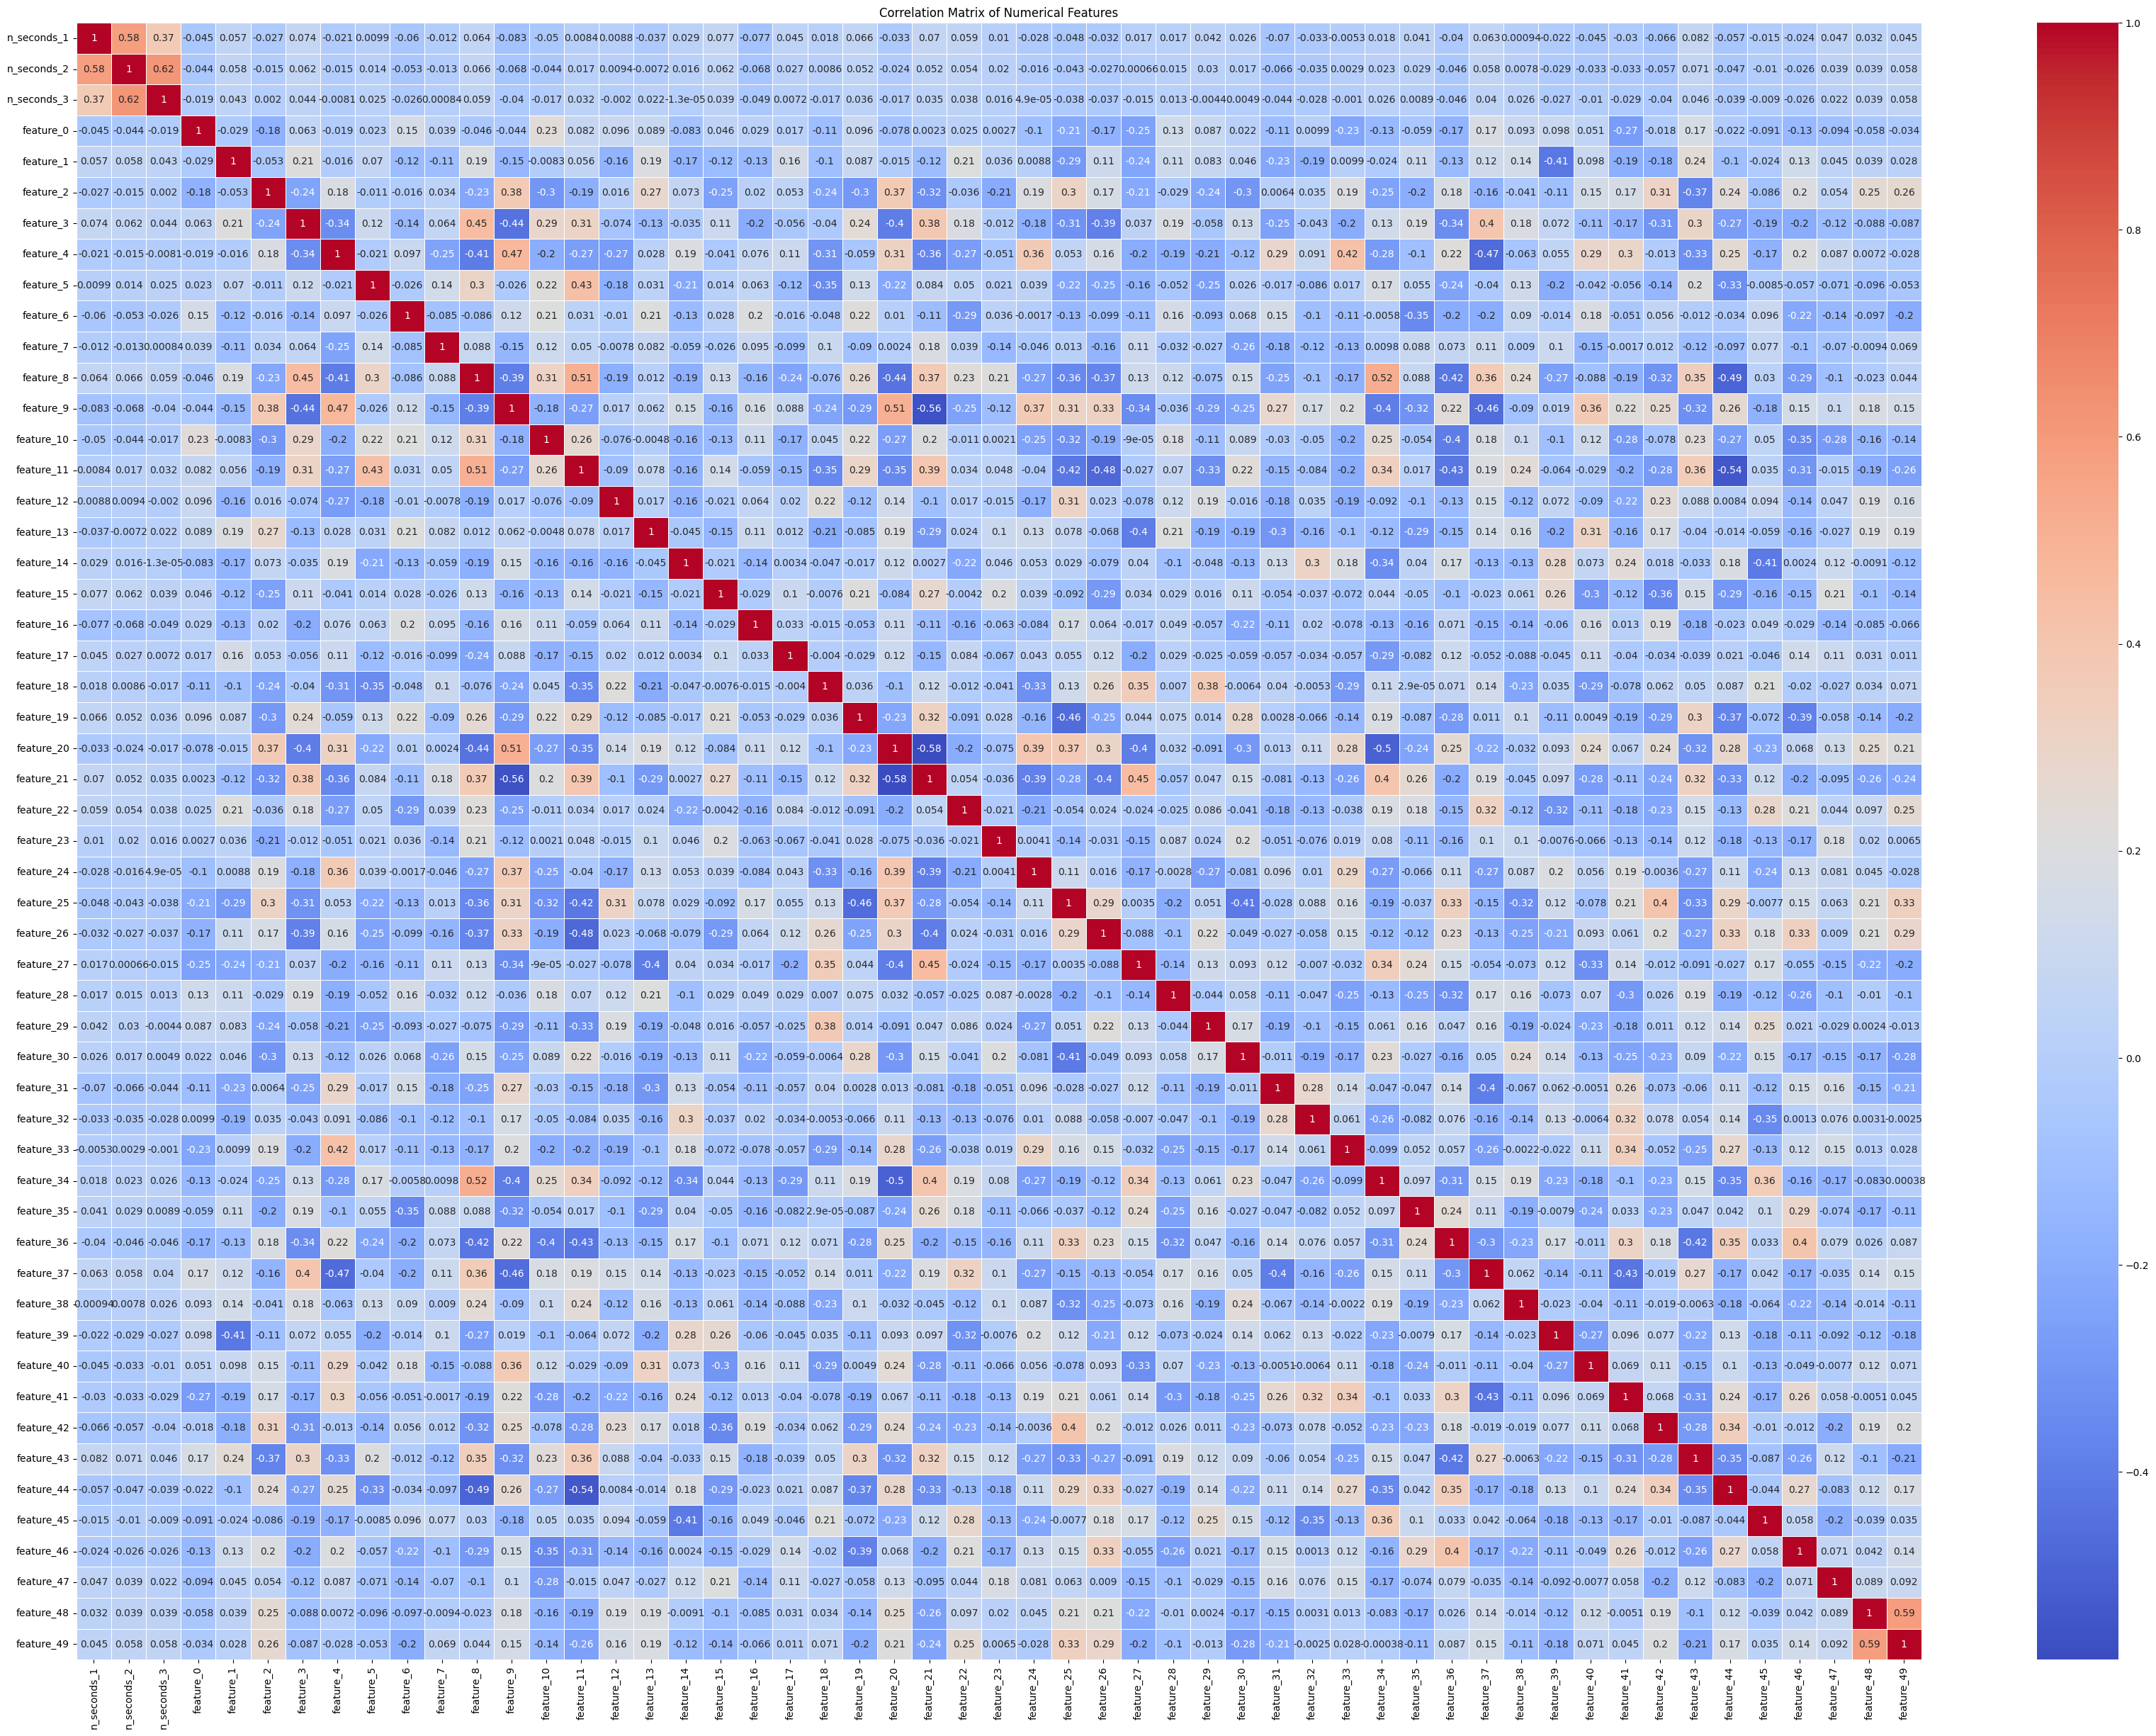

In [10]:
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(42, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [11]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

top_labels = label_counts.head(9).index 

def plot_interactive_boxplot(df, target_df, feature, top_labels):
    traces = []
    for label in top_labels:
        traces.append(
            go.Box(
                y=df[feature],
                x=target_df[label],
                name=label,
                boxmean=True  
            )
        )
    
    layout = go.Layout(
        title=f'Box Plot of {feature}',
        xaxis_title='Label',
        yaxis_title=feature,
        boxmode='group'
    )
    
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

def on_feature_change(change):
    plot_interactive_boxplot(train, target_df, change.new, top_labels)

# Create an interactive dropdown widget
feature_selector = widgets.Dropdown(
    options=numerical_features,
    description='Feature:',
    disabled=False,
)
feature_selector.observe(on_feature_change, names='value')

# Display the dropdown
#display(feature_selector)


## Feature Engineering


In [12]:
def preprocess(df):
    """"""
    numeric_cols = ['n_seconds_1', 'n_seconds_2', 'n_seconds_3',
       'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23',
       'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28',
       'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
       'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43',
       'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48',
       'feature_49']
    categoric_cols = ['carrier', 'devicebrand', 'month'] #month kolonunun verilerin dağılımına göre kategorik olarak işlenmesini daha mantıklı buldum.
    
    #Eksik veri olmadığı için, bunları doldurmaya gerek yok.
    df[numeric_cols] = df[numeric_cols].astype('float64') # Verilerin float64 data tipine dönüştürülmesi
    df[categoric_cols] = df[categoric_cols].astype('category') # Verilerin category data tipine dönüştürülmesi
    
    #kategorik verilerin label-encode işleminden geçirilmesi
    le = LabelEncoder()
    df[categoric_cols] = df[categoric_cols].apply(lambda x: le.fit_transform(x))
    df = df.drop('id', axis=1)
    
    df = feature_eng(df)
    if 'target' in df.columns:
        df['target'] = df['target'].apply(lambda x: [item.strip(' ') for item in x.split(',')])
        mlb = MultiLabelBinarizer()
        target_transformed = mlb.fit_transform(df['target'])
        target_df = pd.DataFrame(target_transformed, columns=mlb.classes_)
        df = df.drop('target', axis=1)
        return df, target_df
    else :
        return df
    
def feature_eng(df):

    df['TimeRatio_1_2'] = df['n_seconds_1'] / df['n_seconds_2']
    df['TimeRatio_1_3'] = df['n_seconds_1'] / df['n_seconds_3']
    
    df['49_times_25'] = df['feature_49'] * df['feature_25']
    df['49_times_35'] = df['feature_49'] * df['feature_35']
    
    df['5_div_11'] = df['feature_5'] / (df['feature_11'] +1e-5)
    df['10_div_9'] = df['feature_10'] / (df['feature_9'] +1e-5)
    return df




In [13]:
train = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/train_final.parquet')
test = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/test_final.parquet')
X, y = preprocess(train)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
test_p = preprocess(test)
test_id = test['id']

## Ensemble Model

#### Approach 

Her bir menu değeri için farklı bir model eğiterek tahminleme yaptım. 




In [14]:
def train_model(model_type, params, X_train, y_train):
    """
    Train a model based on the model type and parameters provided.
    """
    model = get_model(model_type, params)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X, y):
    """
    Evaluate a model and return relevant metrics.
    """
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y, y_pred_proba)
    logloss = log_loss(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    return {
        "AUC": auc,
        "Log Loss": logloss,
        "Accuracy": accuracy
    }

#Helper functions

def custom_jaccard_score(y_true, y_pred):
    score = 0
    for t, p in zip(y_true, y_pred):
        t_indices = np.argsort(t)[::-1]
        p_indices = np.argsort(p)[::-1]
        top3_t = set(t_indices[:3])
        top3_p = set(p_indices[:3])
        intersection = len(top3_t.intersection(top3_p))
        union = len(top3_t) + len(top3_p) - intersection
        score += intersection / union
    return score / len(y_true)

def get_model(model_type, params):
    if model_type == 'catboost':
        params.update({'task_type': "GPU" if gpu_available else "CPU"})
        return CatBoostClassifier(**params, verbose=0, random_state=42)
    elif model_type == 'xgboost':
        params.update({'tree_method': 'gpu_hist' if gpu_available else 'exact'})
        return XGBClassifier(**params, random_state=42)
    elif model_type == 'lightgbm':
        params.update({'device': 'gpu'if gpu_available else 'cpu'}) 
        return LGBMClassifier(**params, random_state=42)

### Ensemble

In [15]:
params = {
   'catboost': {'iterations': 20000, 'learning_rate': 0.01, 'depth': 5, 'task_type': 'GPU', },
   'xgboost' : {'n_estimators': 5000, 'learning_rate': 0.01, 'max_depth': 5, 'gamma': 0.0676932, 'subsample': 0.58, 'colsample_bytree': 0.61, 'tree_method': 'gpu_hist'},
       'lightgbm' : {
        'n_estimators': 10000,
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': -1,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'boosting_type': 'gbdt',
        'reg_alpha': 6.720380454685094,


    }
}


trained_models = defaultdict(dict)
model_metrics = defaultdict(dict)

for label_idx in range(y_train.shape[1]):
    print(f"\nTraining models for label {label_idx}...")
    
    X_train_label, y_train_label = X_train, y_train.iloc[:, label_idx]
    
    for model_type, model_params in params.items():
        print(f"\nTraining {model_type}...")
        
        # Train model
        model = train_model(model_type, model_params, X_train_label, y_train_label)
        
        # Evaluate on training set
        train_metrics = evaluate_model(model, X_train_label, y_train_label)
        print(f"Training metrics for {model_type} on label {label_idx}: {train_metrics}")
        
        # Evaluate on validation set
        val_metrics = evaluate_model(model, X_val, y_val.iloc[:, label_idx])
        print(f"Validation metrics for {model_type} on label {label_idx}: {val_metrics}")
        
        trained_models[label_idx][model_type] = model
        model_metrics[label_idx][model_type] = {
            "train": train_metrics,
            "val": val_metrics
        }

# Aggregated predictions for validation set
y_pred_aggregated = np.zeros((len(X_val), y_train.shape[1]))

# Getting ensemble predictions
for label_idx in range(y_train.shape[1]):
    total_models = len(trained_models[label_idx])
    
    for model_type, model in trained_models[label_idx].items():
        y_pred = model.predict_proba(X_val)[:, 1]
        y_pred_aggregated[:, label_idx] += y_pred / total_models

# Convert y_val to binary indicator matrix
y_true_binary = (y_val.values == 1).astype(int)

# Compute the custom Jaccard score
validation_score = custom_jaccard_score(y_true_binary, y_pred_aggregated)
print(f"\nValidation Jaccard Score for Ensemble: {validation_score}")



Training models for label 0...

Training catboost...


CatBoostError: /src/catboost/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

Modelin büyük ölçüde overfit etmediğini gördükten sonra performansını arttırmak için
Tahminleme öncesi tüm train verisinde eğitiyorum.


In [ ]:
trained_models = defaultdict(dict)
model_metrics= defaultdict(dict)

for label_idx in range(y_train.shape[1]):
    print(f"\nTraining models for label {label_idx}...")
    
    X_train_label, y_train_label = X, y.iloc[:, label_idx]
    
    for model_type, model_params in params.items():
        print(f"\nTraining {model_type}...")
        
        # Train model
        model = train_model(model_type, model_params, X_train_label, y_train_label)
        
        # Evaluate on training set
        train_metrics = evaluate_model(model, X_train_label, y_train_label)
        print(f"Training metrics for {model_type} on label {label_idx}: {train_metrics}")
        

        
        trained_models[label_idx][model_type] = model
        model_metrics[label_idx][model_type] = {
            "train": train_metrics,
            
        }




## Tahminleme 

In [ ]:
def create_submission(trained_models, test_df, test_id):
    # 1. Generate Predictions
    y_pred_aggregated = np.zeros((len(test_df), len(trained_models)))  # Initialize an array to hold the aggregated predictions

    for label_idx in range(len(trained_models)):
        for model_type in trained_models[label_idx]:
            model = trained_models[label_idx][model_type]
            y_pred = model.predict_proba(test_df)[:, 1] 
            y_pred_aggregated[:, label_idx] += y_pred

    # Average the predictions if more than one model per label
    num_models_per_label = len(trained_models[0])  
    y_pred_aggregated /= num_models_per_label

    # 2. Post-Processing
    processed_preds = []
    for pred in y_pred_aggregated:
        # Get the indices of the top 3 predicted labels
        top3_idx = np.argsort(pred)[-3:]

        # Create a binary array of shape (9)
        bin_pred = np.zeros(shape=(9))
        for idx in top3_idx:
            bin_pred[idx] = 1
        processed_preds.append("".join(map(str, bin_pred.astype(int))))

  
    submission_df = pd.DataFrame({
        'id': test_id,
        'target': processed_preds
    })

    
    submission_df.to_csv('submission.csv', index=False)
test = pd.read_parquet('/kaggle/input/turkiye-is-bankasi-ml-challenge-5/test_final.parquet')
test_p = preprocess(test)
create_submission(trained_models, test_p, test['id'])

In [ ]:
trained_models